In [1]:
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt

In [13]:
class image_dehazer():
    def __init__(self, airlightEstimation_windowSze=15, boundaryConstraint_windowSze=3, C0=20, C1=300,
                 regularize_lambda=0.1, sigma=0.5, delta=0.85, showHazeTransmissionMap=True):
        self.airlightEstimation_windowSze = airlightEstimation_windowSze
        self.boundaryConstraint_windowSze = boundaryConstraint_windowSze
        self.C0 = C0
        self.C1 = C1
        self.regularize_lambda = regularize_lambda
        self.sigma = sigma
        self.delta = delta
        self.showHazeTransmissionMap = showHazeTransmissionMap
        self._A = []
        self._transmission = []
        self._WFun = []

    def __AirlightEstimation(self, HazeImg):
        if (len(HazeImg.shape) == 3):
            for ch in range(len(HazeImg.shape)):
                kernel = np.ones((self.airlightEstimation_windowSze, self.airlightEstimation_windowSze), np.uint8)
                minImg = cv2.erode(HazeImg[:, :, ch], kernel)
                self._A.append(int(minImg.max()))
        else:
            kernel = np.ones((self.airlightEstimation_windowSze, self.airlightEstimation_windowSze), np.uint8)
            minImg = cv2.erode(HazeImg, kernel)
            self._A.append(int(minImg.max()))

    def __BoundCon(self, HazeImg):
        if (len(HazeImg.shape) == 3):

            t_b = np.maximum((self._A[0] - HazeImg[:, :, 0].astype(float)) / (self._A[0] - self.C0),
                             (HazeImg[:, :, 0].astype(float) - self._A[0]) / (self.C1 - self._A[0]))
            t_g = np.maximum((self._A[1] - HazeImg[:, :, 1].astype(float)) / (self._A[1] - self.C0),
                             (HazeImg[:, :, 1].astype(float) - self._A[1]) / (self.C1 - self._A[1]))
            t_r = np.maximum((self._A[2] - HazeImg[:, :, 2].astype(float)) / (self._A[2] - self.C0),
                             (HazeImg[:, :, 2].astype(float) - self._A[2]) / (self.C1 - self._A[2]))

            MaxVal = np.maximum(t_b, t_g, t_r)
            self._Transmission = np.minimum(MaxVal, 1)
        else:
            self._Transmission = np.maximum((self._A[0] - HazeImg.astype(float)) / (self._A[0] - self.C0),
                                            (HazeImg.astype(float) - self._A[0]) / (self.C1 - self._A[0]))
            self._Transmission = np.minimum(self._Transmission, 1)

        kernel = np.ones((self.boundaryConstraint_windowSze, self.boundaryConstraint_windowSze), float)
        self._Transmission = cv2.morphologyEx(self._Transmission, cv2.MORPH_CLOSE, kernel=kernel)

    def __LoadFilterBank(self):
        KirschFilters = []
        KirschFilters.append(np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]))
        KirschFilters.append(np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]))
        KirschFilters.append(np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]))
        KirschFilters.append(np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]))
        KirschFilters.append(np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]))
        KirschFilters.append(np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]))
        KirschFilters.append(np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]))
        KirschFilters.append(np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]))
        KirschFilters.append(np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]))
        return (KirschFilters)

    def __CalculateWeightingFunction(self, HazeImg, Filter):

        # Computing the weight function... Eq (17) in the paper

        HazeImageDouble = HazeImg.astype(float) / 255.0
        if (len(HazeImg.shape) == 3):
            Red = HazeImageDouble[:, :, 2]
            d_r = self.__circularConvFilt(Red, Filter)

            Green = HazeImageDouble[:, :, 1]
            d_g = self.__circularConvFilt(Green, Filter)

            Blue = HazeImageDouble[:, :, 0]
            d_b = self.__circularConvFilt(Blue, Filter)

            return (np.exp(-((d_r ** 2) + (d_g ** 2) + (d_b ** 2)) / (2 * self.sigma * self.sigma)))
        else:
            d = self.__circularConvFilt(HazeImageDouble, Filter)
            return (np.exp(-((d ** 2) + (d ** 2) + (d ** 2)) / (2 * self.sigma * self.sigma)))

    def __circularConvFilt(self, Img, Filter):
        FilterHeight, FilterWidth = Filter.shape
        assert (FilterHeight == FilterWidth), 'Filter must be square in shape --> Height must be same as width'
        assert (FilterHeight % 2 == 1), 'Filter dimension must be a odd number.'

        filterHalsSize = int((FilterHeight - 1) / 2)
        rows, cols = Img.shape
        PaddedImg = cv2.copyMakeBorder(Img, filterHalsSize, filterHalsSize, filterHalsSize, filterHalsSize,
                                       borderType=cv2.BORDER_WRAP)
        FilteredImg = cv2.filter2D(PaddedImg, -1, Filter)
        Result = FilteredImg[filterHalsSize:rows + filterHalsSize, filterHalsSize:cols + filterHalsSize]
        return (Result)

    def __CalTransmission(self, HazeImg):
        rows, cols = self._Transmission.shape

        KirschFilters = self.__LoadFilterBank()

        # Normalize the filters
        for idx, currentFilter in enumerate(KirschFilters):
            KirschFilters[idx] = KirschFilters[idx] / np.linalg.norm(currentFilter)

        # Calculate Weighting function --> [rows, cols. numFilters] --> One Weighting function for every filter
        WFun = []
        for idx, currentFilter in enumerate(KirschFilters):
            WFun.append(self.__CalculateWeightingFunction(HazeImg, currentFilter))

        # Precompute the constants that are later needed in the optimization step
        tF = np.fft.fft2(self._Transmission)
        DS = 0

        for i in range(len(KirschFilters)):
            D = self.__psf2otf(KirschFilters[i], (rows, cols))
            # D = psf2otf(KirschFilters[i], (rows, cols))
            DS = DS + (abs(D) ** 2)

        # Cyclic loop for refining t and u --> Section III in the paper
        beta = 1  # Start Beta value --> selected from the paper
        beta_max = 2 ** 4  # Selected from the paper --> Section III --> "Scene Transmission Estimation"
        beta_rate = 2 * np.sqrt(2)  # Selected from the paper

        while (beta < beta_max):
            gamma = self.regularize_lambda / beta

            # Fixing t first and solving for u
            DU = 0
            for i in range(len(KirschFilters)):
                dt = self.__circularConvFilt(self._Transmission, KirschFilters[i])
                u = np.maximum((abs(dt) - (WFun[i] / (len(KirschFilters) * beta))), 0) * np.sign(dt)
                DU = DU + np.fft.fft2(self.__circularConvFilt(u, cv2.flip(KirschFilters[i], -1)))

            # Fixing u and solving t --> Equation 26 in the paper
            # Note: In equation 26, the Numerator is the "DU" calculated in the above part of the code
            # In the equation 26, the Denominator is the DS which was computed as a constant in the above code

            self._Transmission = np.abs(np.fft.ifft2((gamma * tF + DU) / (gamma + DS)))
            beta = beta * beta_rate

        # if (self.showHazeTransmissionMap):
        #     cv2.imshow("Haze Transmission Map", self._Transmission)
        #     cv2.waitKey(1)

    def __removeHaze(self, HazeImg):
        '''
        :param HazeImg: Hazy input image
        :param Transmission: estimated transmission
        :param A: estimated airlight
        :param delta: fineTuning parameter for dehazing --> default = 0.85
        :return: result --> Dehazed image
        '''

        # This function will implement equation(3) in the paper
        # " https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Meng_Efficient_Image_Dehazing_2013_ICCV_paper.pdf "

        epsilon = 0.0001
        Transmission = pow(np.maximum(abs(self._Transmission), epsilon), self.delta)

        HazeCorrectedImage = copy.deepcopy(HazeImg)
        if (len(HazeImg.shape) == 3):
            for ch in range(len(HazeImg.shape)):
                temp = ((HazeImg[:, :, ch].astype(float) - self._A[ch]) / Transmission) + self._A[ch]
                temp = np.maximum(np.minimum(temp, 255), 0)
                HazeCorrectedImage[:, :, ch] = temp
        else:
            temp = ((HazeImg.astype(float) - self._A[0]) / Transmission) + self._A[0]
            temp = np.maximum(np.minimum(temp, 255), 0)
            HazeCorrectedImage = temp
        return (HazeCorrectedImage)


    def Background(self,RGB):
        height, width, _ = RGB.shape
        patchSize = 3
        padSize = 1  # half the patch size
        JBack = np.zeros((height, width))

        # Padding the RGB image with Inf (We use a high value to simulate Inf since actual Infinity might cause issues)
        imJ = np.pad(RGB, [(padSize, padSize), (padSize, padSize), (0, 0)], mode='constant', constant_values=1)

        for j in range(height):
            for i in range(width):
                # Extracting the patch
                patch = imJ[j:j+patchSize, i:i+patchSize, :]

                # Assigning the maximum value of the patch to JBack
                JBack[j, i] = np.max(patch)

        return JBack

    def Compensation(self,fog_free_layer, G):
        # Compute the background
        JBack = np.abs(self.Background(fog_free_layer))

        # Display using Matplotlib
    #     plt.imshow(JBack, cmap='gray')
    #     plt.show()

        # Save the data using SciPy's savemat
        
        # Clip and modify values in JBack
        JBack[JBack > 1] = 1
        JBack[JBack == 0] = 0.001

        # Calculate GR and Gm
        GR = G[:,:,np.newaxis] * fog_free_layer
        Gm = GR / JBack[:,:,np.newaxis]

        return Gm


    def __psf2otf(self, psf, shape):
        '''
            this code is taken from:
            https://pypi.org/project/pypher/
        '''
        """
        Convert point-spread function to optical transfer function.

        Compute the Fast Fourier Transform (FFT) of the point-spread
        function (PSF) array and creates the optical transfer function (OTF)
        array that is not influenced by the PSF off-centering.
        By default, the OTF array is the same size as the PSF array.

        To ensure that the OTF is not altered due to PSF off-centering, PSF2OTF
        post-pads the PSF array (down or to the right) with zeros to match
        dimensions specified in OUTSIZE, then circularly shifts the values of
        the PSF array up (or to the left) until the central pixel reaches (1,1)
        position.

        Parameters
        ----------
        psf : `numpy.ndarray`
            PSF array
        shape : int
            Output shape of the OTF array

        Returns
        -------
        otf : `numpy.ndarray`
            OTF array

        Notes
        -----
        Adapted from MATLAB psf2otf function

        """
        if np.all(psf == 0):
            return np.zeros_like(psf)

        inshape = psf.shape
        # Pad the PSF to outsize
        psf = self.__zero_pad(psf, shape, position='corner')

        # Circularly shift OTF so that the 'center' of the PSF is
        # [0,0] element of the array
        for axis, axis_size in enumerate(inshape):
            psf = np.roll(psf, -int(axis_size / 2), axis=axis)

        # Compute the OTF
        otf = np.fft.fft2(psf)

        # Estimate the rough number of operations involved in the FFT
        # and discard the PSF imaginary part if within roundoff error
        # roundoff error  = machine epsilon = sys.float_info.epsilon
        # or np.finfo().eps
        n_ops = np.sum(psf.size * np.log2(psf.shape))
        otf = np.real_if_close(otf, tol=n_ops)

        return otf

    def __zero_pad(self, image, shape, position='corner'):
        """
        Extends image to a certain size with zeros

        Parameters
        ----------
        image: real 2d `numpy.ndarray`
            Input image
        shape: tuple of int
            Desired output shape of the image
        position : str, optional
            The position of the input image in the output one:
                * 'corner'
                    top-left corner (default)
                * 'center'
                    centered

        Returns
        -------
        padded_img: real `numpy.ndarray`
            The zero-padded image

        """
        shape = np.asarray(shape, dtype=int)
        imshape = np.asarray(image.shape, dtype=int)

        if np.alltrue(imshape == shape):
            return image

        if np.any(shape <= 0):
            raise ValueError("ZERO_PAD: null or negative shape given")

        dshape = shape - imshape
        if np.any(dshape < 0):
            raise ValueError("ZERO_PAD: target size smaller than source one")

        pad_img = np.zeros(shape, dtype=image.dtype)

        idx, idy = np.indices(imshape)

        if position == 'center':
            if np.any(dshape % 2 != 0):
                raise ValueError("ZERO_PAD: source and target shapes "
                                 "have different parity.")
            offx, offy = dshape // 2
        else:
            offx, offy = (0, 0)

        pad_img[idx + offx, idy + offy] = image

        return pad_img

    def remove_haze(self, HazeImg):
        self.__AirlightEstimation(HazeImg)
        self.__BoundCon(HazeImg)
        self.__CalTransmission(HazeImg)
        haze_corrected_img = self.__removeHaze(HazeImg)
        HazeTransmissionMap = self._Transmission
        Gm = self.Compensation(haze_corrected_img/255, HazeTransmissionMap)
        result = (haze_corrected_img/255) + (0.5 * Gm)
        result = (result/np.max(result))*255
        result = result.astype(np.uint8)
        return (result,haze_corrected_img, HazeTransmissionMap)

In [14]:
HazeImg = cv2.imread("C:\\Users\\CGLAB\Desktop\\Defogging\\python files\\Test_Data\\V_07_01_0017.jpg")						# read input image -- (**must be a color image**)
HazeImg = cv2.cvtColor(HazeImg, cv2.COLOR_RGB2BGR)
Img_DH = image_dehazer(airlightEstimation_windowSze=8, boundaryConstraint_windowSze=3, C0=20, C1=255,
                      regularize_lambda=0.1, sigma=0.5, delta=0.85)
Result,HazeCorrectedImg, haze_map = Img_DH.remove_haze(HazeImg = HazeImg)

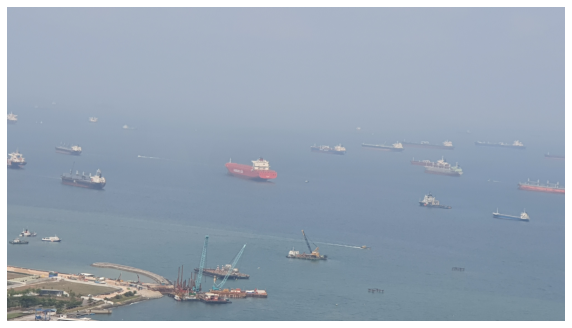

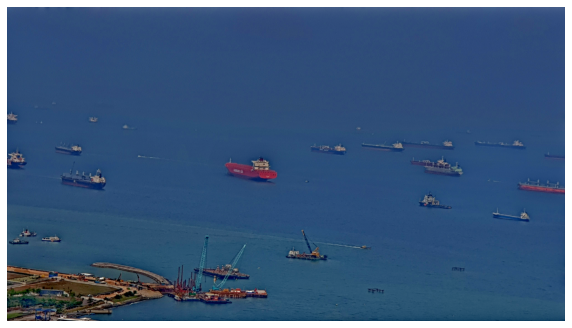

In [18]:
HazeImg = cv2.imread("C:\\Users\\CGLAB\Desktop\\Defogging\\python files\\Test_Data\\V_08_01_0014.jpg")						# read input image -- (**must be a color image**)
HazeImg = cv2.cvtColor(HazeImg, cv2.COLOR_RGB2BGR)
Img_DH = image_dehazer(airlightEstimation_windowSze=8, boundaryConstraint_windowSze=3, C0=20, C1=255,
                      regularize_lambda=0.1, sigma=0.5, delta=0.85)
Result,HazeCorrectedImg, haze_map = Img_DH.remove_haze(HazeImg = HazeImg)
plt.figure(figsize=(10,10))
plt.imshow(HazeImg)
plt.axis('off')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(Result)
plt.axis('off')
plt.show()

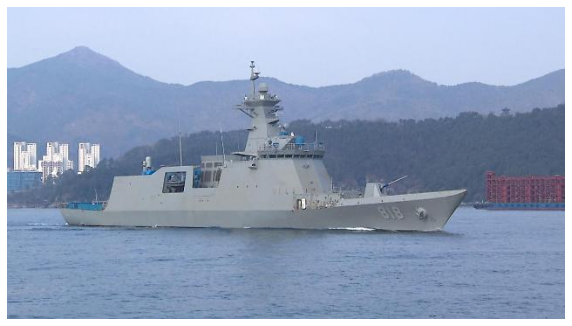

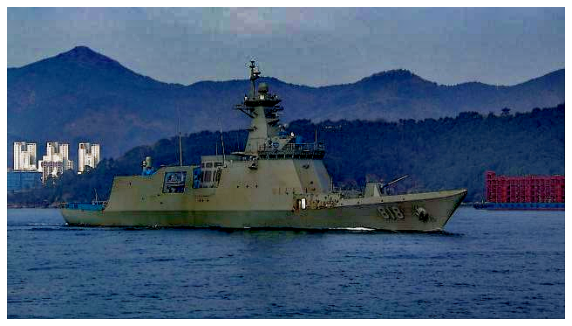

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(HazeImg)
plt.axis('off')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(Result)
plt.axis('off')
plt.show()

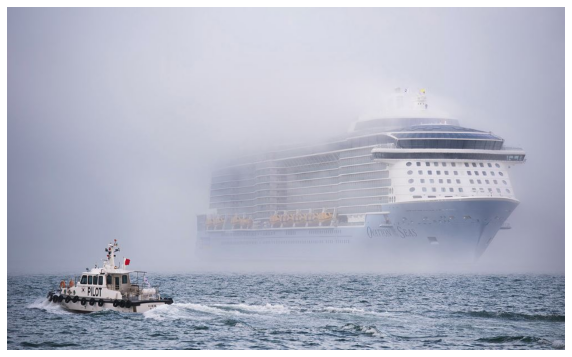

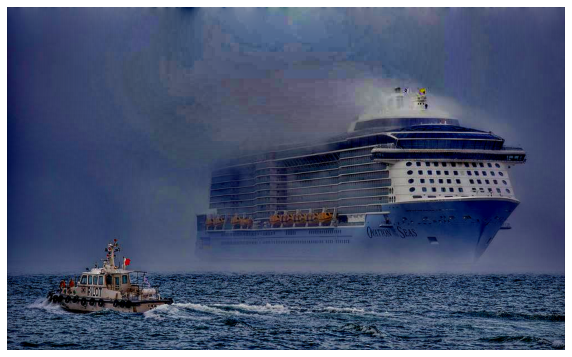

In [20]:
HazeImg = cv2.imread("C:\\Users\\CGLAB\Desktop\\Defogging\\python files\\Test_Data\\V_07_01_0014.jpg")						# read input image -- (**must be a color image**)
HazeImg = cv2.cvtColor(HazeImg, cv2.COLOR_RGB2BGR)
Img_DH = image_dehazer(airlightEstimation_windowSze=8, boundaryConstraint_windowSze=3, C0=20, C1=255,
                      regularize_lambda=0.1, sigma=0.5, delta=0.85)
Result,HazeCorrectedImg, haze_map = Img_DH.remove_haze(HazeImg = HazeImg)
plt.figure(figsize=(10,10))
plt.imshow(HazeImg)
plt.axis('off')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(Result)
plt.axis('off')
plt.show()

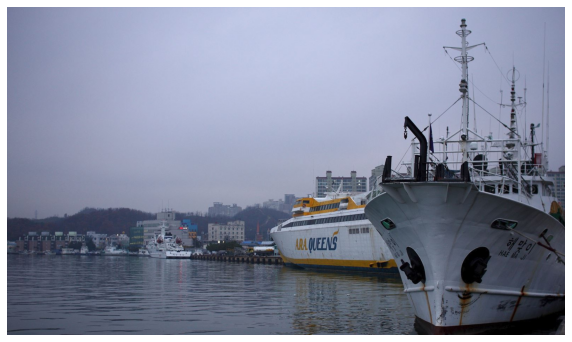

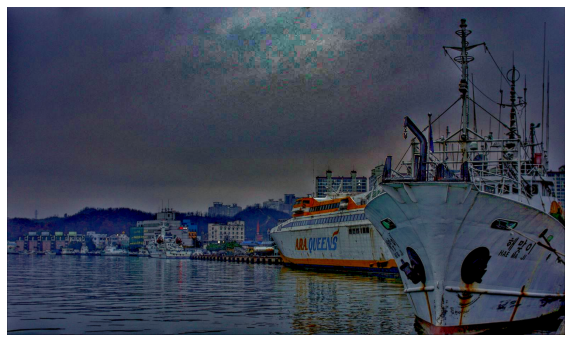

In [17]:
HazeImg = cv2.imread("C:\\Users\\CGLAB\Desktop\\Defogging\\python files\\Test_Data\\V_07_01_0015.jpg")						# read input image -- (**must be a color image**)
HazeImg = cv2.cvtColor(HazeImg, cv2.COLOR_RGB2BGR)
Img_DH = image_dehazer(airlightEstimation_windowSze=8, boundaryConstraint_windowSze=3, C0=20, C1=255,
                      regularize_lambda=0.1, sigma=0.5, delta=0.85)
Result,HazeCorrectedImg, haze_map = Img_DH.remove_haze(HazeImg = HazeImg)
plt.figure(figsize=(10,10))
plt.imshow(HazeImg)
plt.axis('off')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(Result)
plt.axis('off')
plt.show()